# Schedulers in PyTorch

Welcome to this exploration of learning rate schedulers in PyTorch! As you have learned in the lectures, managing learning rates is vital to optimizing model training, and PyTorch provides various tools to streamline this process. Learning rate schedulers are essential for dynamically adjusting learning rates according to the training phase, helping to facilitate faster convergence and improve generalization.

In this notebook, you will dive into the mechanics of different learning rate schedulers. Specifically, you will:

* Explore how schedulers like `StepLR`, `CosineAnnealingLR`, and `ReduceLROnPlateau` adjust the learning rate to maintain training efficiency.

* Use these schedulers within a typical training loop.

* Learn to visualize training dynamics, demonstrating the impact of schedulers on model performance compared to a constant learning rate.

By the end of this notebook, you will have practical experience in applying learning rate schedulers, enhancing your understanding of their role in model training.

In [38]:
import sys
import time
import warnings

import os
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

#To catch other potential messages

class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass

sys.stderr = BlackHole()

#Ignore python level user warinign
warnings.filterwarnings("ignore", category=UserWarning)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import helper

helper.set_seed(42)
device = torch.device("mps")

## A deeper dive into the training process

In this section you will make a deeper analysis of the experiments we have done in the previous lab. 
You will use a simple model (`SimpleCNN`) and the CIFAR-10 dataset, but now we will inspect the training process more closely by plotting the **training loss** and **validation accuracy** curves.

This will help use understand how the model learns over time and how different learning rates affect the training dynamics.

In the following cell we find `SimpleCNN` model definition, and `evaluate_epoch` function that you can use to evaluate the model on the validation set *after each epoch*.
`train_and_evaluate` function is provided to train the model for a specified number of epochs and evaluate it during training.

`get_data_loaders`and `train_epoch` functions are provided from `helper_utils` module. 
They are used to load the CIFAR-10 dataset and train the model for one epoch, respectively.

In [43]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """

    def __init__(self):
        """Initializes the layer of the nueral network"""

        super(SimpleCNN, self).__init__()

        #First convolution layer (3 inut channels, 16 output channels,3X3 kernal)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, padding=1)

        #Max poolinglayer. with a 2X2 windows and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        #Fully connected layer
        self.fc1=nn.Linear(32 * 8 * 8, 64)
        self.fc2 =nn.Linear(64, 10)

        #Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.4)


    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """
        #Apply first convolution, ReLU activation, and max pooling

        x = self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        #Flatten the feature map for fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        #Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        #Apply the final output layer 
        x = self.fc2(x)
        return x

def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128, p_bar=None):
    """Orchestrates the training and evaluation of a model for a given configuration.

    This function handles the end-to-end workflow: setting a random seed,
    initializing the model, optimizer, loss function, and dataloaders, and then
    running the main training loop.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of training epochs. Defaults to 25.
        batch_size (int, optional): The batch size for dataloaders. Defaults to 128.
        p_bar (optional): An existing progress bar handler. Defaults to None.

    Returns:
        dict: A dictionary containing the training and validation history
              (loss and accuracy).
    """
    #Set the random seed
    helper.set_seed(42)

    #Initialize the model and move it to the specific device
    model = SimpleCNN().to(device)

    #Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    #Prepare the training and validation dataloader 
    train_loader, val_loader = helper.get_dataset_dataloaders(
        batch_size=batch_size
    )

    #Call the main training loop to train the model and get the history
    history =helper.train_model(
        model=model,
        optimizer=optimizer,
        loss_fcn=loss_fn,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        device=device,
        n_epochs=n_epochs,
        p_bar=p_bar
    )

    #Return the collected training history
    return history


Now the model is trained for several epochs for each of the specified learning rates.
The results are stored in `training_curves`, and the curves (train loss and validation accuracy) are plotted for each learning rate.

In [44]:
#Different learning rates to be analyed
learning_rates = [0.0002, 0.001, 0.005]

training_curves = []
n_epochs = 25
batch_size = 128

p_bar = helper.get_p_bar(n_epochs)

#Get the total number of learning rates to check against the index
num_learning_rates = len(learning_rates)

#Train and evaluate the model for each learning rate
for i, lr in enumerate(learning_rates):
    print(f"Training with learning rate: {lr}")
    history = train_and_evaluate(learning_rate=lr, n_epochs=n_epochs, batch_size=batch_size, device=device,p_bar=p_bar)
    training_curves.append(history)

    #Only reset the progress bar if it's not the last iteration
    if i<num_learning_rates-1:
        p_bar.reset()

Training with learning rate: 0.0002
At epoch 5: Training loss: 1.7788, Training accuracy: 0.3590
At epoch 5: Validation loss: 1.6774, Validation accuracy: 0.4160
At epoch 10: Training loss: 1.5925, Training accuracy: 0.4263
At epoch 10: Validation loss: 1.5138, Validation accuracy: 0.4705
At epoch 15: Training loss: 1.4607, Training accuracy: 0.4688
At epoch 15: Validation loss: 1.4392, Validation accuracy: 0.4910
At epoch 20: Training loss: 1.3874, Training accuracy: 0.5020
At epoch 20: Validation loss: 1.3957, Validation accuracy: 0.5065
At epoch 25: Training loss: 1.3367, Training accuracy: 0.5125
At epoch 25: Validation loss: 1.3478, Validation accuracy: 0.5105
Training complete

Training with learning rate: 0.001
At epoch 5: Training loss: 1.5155, Training accuracy: 0.4476
At epoch 5: Validation loss: 1.4282, Validation accuracy: 0.4920
At epoch 10: Training loss: 1.3286, Training accuracy: 0.5185
At epoch 10: Validation loss: 1.3224, Validation accuracy: 0.5295
At epoch 15: Train

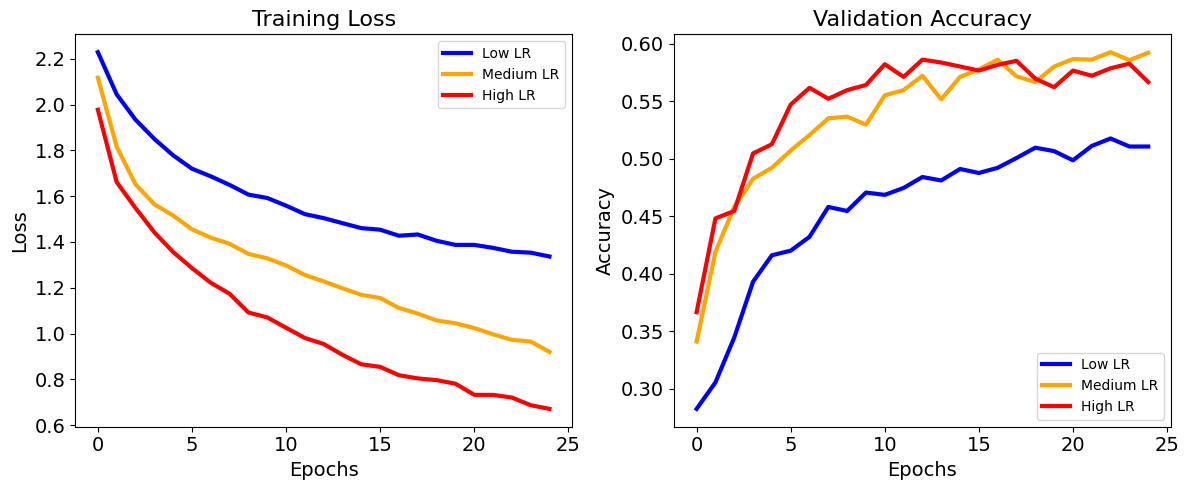

In [45]:
color = ['blue', 'orange', 'red']
labels = ['Low LR', 'Medium LR', 'High LR']

helper.plot_learning_curves(color, labels, training_curves)

### Learning Rate Analysis

Each color represents a different learning rate: blue for low, orange for medium, and red for high.

- **Low Learning Rate:**
The validation accuracy improves gradually and may require a significant amount of time (many epochs) to reach its peak.

- **Medium Learning Rate:**
The validation accuracy increases quickly, and by the end of the 25 epochs, it is outperforming the other two models.

- **High Learning Rate:**
Initially, validation accuracy is the highest during the first few epochs but eventually levels off, indicating instability where the model struggles to improve with such a high learning rate.

Among these options, the medium learning rate strikes the best balance between learning speed and generalization. Could you achieve a better model by combining these learning rates—starting with a high rate for the first few epochs, then transitioning to medium, and finally to low?

</br>

## Schedulers
In the previous section, you explored how the choice of learning rate impacts model performance. A high learning rate can lead to instability, while a low one might slow down training or yield suboptimal outcomes. Learning rate schedulers offer a solution by automatically adjusting the learning rate throughout training, initially setting it high for rapid learning and then reducing it to enhance convergence and generalization.

In this lab, you'll investigate three different schedulers. Let's start with the `StepLR` scheduler, which lowers the learning rate by a specified factor at regular intervals—specifically, after a set number of epochs. You'll repeat the training process from before, but this time you'll employ a scheduler that decreases the learning rate by a factor of 0.2 every 10 epochs.

In [ ]:
helper.set_seed(42)

#Initialize the model,optimizer,loss function and dataloaders
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005) 

Schedulers are built into the PyTorch `torch.optim.lr_scheduler` module and can be easily integrated into your training loop.
You typically initialize a scheduler with the optimizer and parameters that define how the learning rate changes over time.

The `StepLR` scheduler, for example:
  - Takes the optimizer as input.
  - Requires `step_size`, the number of epochs before reducing the learning rate.
  - Uses a `gamma` factor, the factor by which the learning rate is reduced.

In [47]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2) #Reducethe learning rate by 20% it's prior value

The training process is similar to the previous one, but the learning rate is adjusted by the scheduler after each epoch using the `scheduler.step()` method.
The current learning rate can be accessed using `scheduler.get_last_lr()`.

The model is trained for several epochs with the `StepLR` scheduler, and the training curves are plotted to compare the results with the previous experiments for the medium learning rate.

In [48]:
loss_fn = nn.CrossEntropyLoss()

train_loader, val_loader = helper.get_dataset_dataloaders(batch_size=batch_size)

history_LR = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "lr": []
}

pbar = helper.NestedProgressBar(
    total_batches=len(train_loader),
    total_epochs=n_epochs,
    epoch_message_freq=5,
    mode="train"
)

for epoch in range(n_epochs):
    pbar.update_epoch(epoch +1)

    #Train the model for one epoch
    train_loss, train_acc = helper.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)

    #Evaludate the model on training set
    val_loss, val_acc = helper.evaluate_epoch(model, val_loader, loss_fn, device)

    #Get the current learning rate before stepping the scheduler
    #This captuer the LR that was just used for the training epoch above
    current_lr = scheduler.get_last_lr()[0]

    #Step the scheculer (update the LR for the next epoch)
    scheduler.step()

    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At eepoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc: .4f}, LR: {current_lr: .6f}")
    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch{epoch+1}: Valication loss: {val_loss:.4f}, Validation accuracy: {val_acc: .4f}")

    history_LR["train_loss"].append(train_loss)
    history_LR["train_acc"].append(train_acc)
    history_LR["val_loss"].append(val_loss)
    history_LR["val_acc"].append(val_acc)
    history_LR["lr"].append(current_lr)

pbar.close("Training complete with StepLR schduler")

At eepoch 5: Training loss: 1.3562, Training accuracy:  0.4936, LR:  0.005000
At epoch5: Valication loss: 1.3222, Validation accuracy:  0.5125
At eepoch 10: Training loss: 1.0704, Training accuracy:  0.6010, LR:  0.005000
At epoch10: Valication loss: 1.2429, Validation accuracy:  0.5640
At eepoch 15: Training loss: 0.8122, Training accuracy:  0.6944, LR:  0.001000
At epoch15: Valication loss: 1.2029, Validation accuracy:  0.5880
At eepoch 20: Training loss: 0.7457, Training accuracy:  0.7060, LR:  0.001000
At epoch20: Valication loss: 1.2445, Validation accuracy:  0.5920
At eepoch 25: Training loss: 0.6957, Training accuracy:  0.7328, LR:  0.000200
At epoch25: Valication loss: 1.2587, Validation accuracy:  0.5925
Training complete with StepLR schduler


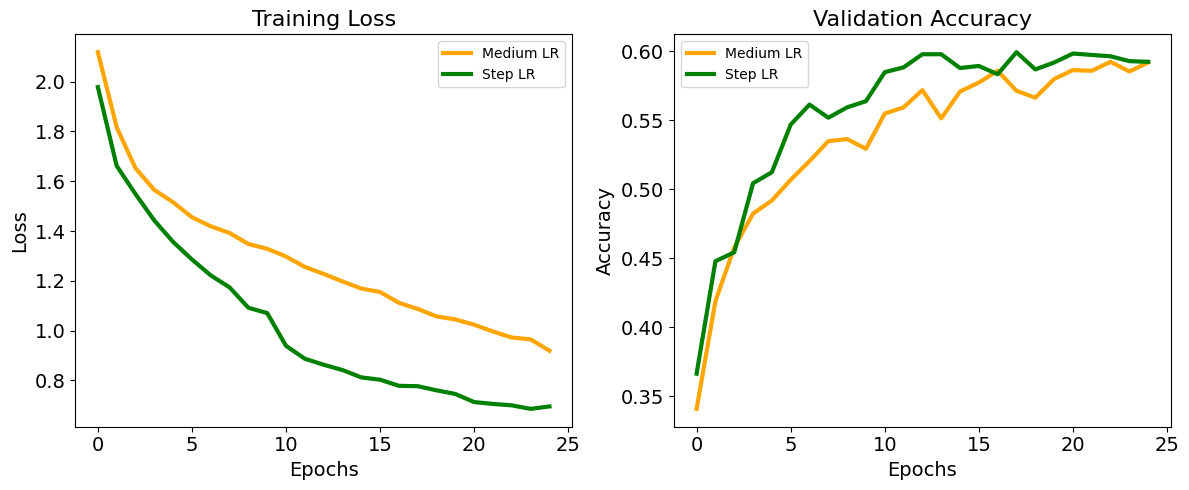

In [49]:
idx=1
history_constant = training_curves[idx]
color = ['orange', 'green']
labels = ['Medium LR', 'Step LR']

histories = [history_constant, history_LR]

helper.plot_learning_curves(color, labels, histories)